In [2]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding



from keras.preprocessing.text import text_to_word_sequence


from keras.models import Model


from keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, MaxPooling1D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.layers import SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D

from keras.callbacks import Callback
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.utils.vis_utils import plot_model

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer


# Other
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from nltk.stem import WordNetLemmatizer 
from sklearn.cross_validation import train_test_split

In [3]:
df=pd.read_csv('rdc-catalog-train.tsv',delimiter='\t',encoding='utf-8',header=None)

In [4]:
df.columns = ['text', 'label']

In [5]:
df=df.sample(frac=1,random_state=42)

In [7]:
def standardize_metrics(text):
    text = re.sub(r'\b[\d\.\/]+\s?(v|volt)\b', 'metricV', text)
    text = re.sub(r'\b[\d\.\/]+\s?(amp|amps|ampere|amperes)\b', 'metricA', text)
    text = re.sub(r'\b[\d\.\/]+\s?(mah|ah|ampere-hour)\b', 'metricAh', text)
    text = re.sub(r'\b[\d\.\/]+\s?(in|inch|inches)\b', 'metricIn', text)
    text = re.sub(r'\b[\d\.\/]+\s?\"', 'metricIn', text)
    text = re.sub(r'\b[\d\.\/]+\s?(gb|gig|go|giga|gigabit|gigabyte)\b', 'metricGb', text)
    text = re.sub(r'\b[\d\.\/]+\s?(oz|ounce)\b', 'metricOz', text)
    text = re.sub(r'\b[\d\.\/]+\s?(fl\.? oz\.?|fluids? ounces?)\b', 'metricFlOz', text)
    text = re.sub(r'\b[\d\.\/]+\s?(cwt|quintal)\b', 'metricCwt', text)
    text = re.sub(r'\b[\d\.\/]+\s?(mhz|hz|khz|ghz|gigahertz|megahertz|kilohertz|hertz)\b', 'metricHz', text)
    text = re.sub(r'\b[\d\.\/]+\s?(wh|kwh|watt-hour|kilowatt-hour)\b', 'metricWh', text)
    text = re.sub(r'\b[\d\.\/]+\s?(w|kw|watt|kilowatt)\b', 'metricW', text)
    text = re.sub(r'\b[\d\.\/]+\s?(mf|mfd|mmf|mmfd|microfarad)\b', 'metricMfd', text)
    text = re.sub(r'\b[\d\.\/]+\s?(ft|feet|foot)\b', 'metricFt', text)
    text = re.sub(r'\b[\d\.\/]+\s?(cm|centimeter)\b', 'metricCm', text)
    text = re.sub(r'\b[\d\.\/]+\s?(mm|millimeter)\b', 'metricMm', text)
    text = re.sub(r'\b[\d\.\/]+\s?(km|kilometer)\b', 'metricKm', text)
    text = re.sub(r'\b[\d\.\/]+\s?(m|meter)\b', 'metricM', text)
    text = re.sub(r'\b[\d\.\/]+\s?(cell|cells)\b', 'metricCell', text)
    text = re.sub(r'\b[\d\.\/]+\s?(lb|lbs|pound)\b', 'metricLb', text)
    text = re.sub(r'\b[\d\.\/]+\s?(yds|yd|yard|yards)\b', 'metricYd', text)
    text = re.sub(r'\b[\d\.\/]+\s?(pc|pcs|pieces|piece)\b', 'metricPc', text)
    text = re.sub(r'\b[\d\.\/]+\s?(gal|gals|gallon|gallons)\b', 'metricGal', text)
    text = re.sub(r'\b[\d\.\/]+\s?(yd|yds|yard|yards)\b', 'metricYd', text)
    text = re.sub(r'\b[\d\.\/]+\s?(deg|degs|degree|degrees)\b', 'metricDeg', text)
    text = re.sub(r'\b[\d\.\/]+\s?\°', 'metricDeg', text)
    text = re.sub(r'\b[\d\.\/]+\s?(l|liter|liters)\b', 'metricL', text)
    text = re.sub(r'\b[\d\.\/]+\s?(ml|mls|milliliter|milliliters)\b', 'metricMl', text)
    text = re.sub(r'\b[\d\.\/]+\s?(kg|kilograms|kilogram)\b', 'metricKg', text)
    text = re.sub(r'\b[\d\.\/]+\s?(g|grams|gram)\b', 'metricG', text)
    text = re.sub(r'\b[\d\.\/]+\s?(mg|mgs|milligrams|milligram)\b', 'metricMg', text)
    text = re.sub(r'\b[\d\.\/]+\s?(sq|sqs|square|squares)\b', 'metricSq', text)
    text = re.sub(r'\b[\d\.\/]+\s?(pt|pts|pint|pints)\b', 'metricPt', text)
    text = re.sub(r'\b[\d\.\/]+\s?(ohm)\b', 'metricOhm', text)
    text = re.sub(r'\b[\d\.\/]+\s?(fz)\b', 'metricFz', text)
    text = re.sub(r'\b[\d\.\/]+\s?(ct|cts|carat|carats)\b', 'metricCt', text)
    text = re.sub(r'\b[\d]+p\b', 'metricRes', text)
    text = re.sub(r'\b[\d]+x[\d]+\b', 'metricRes', text)
    text = re.sub(r'\b[\d]+x\b', 'metricX', text)
    return text

def clean_text_standard_metrics_v0plus(text):
    text = text.lower()
    #text = standardize_metrics(text)
    #text = re.sub(r'\b\d*\.\d+\b', 'nbDec', text)
    #text = re.sub(r'\b\d+\/\d+\b', 'nbFra', text)
    #text = re.sub(r'\b\d+\b', 'nbNat', text)
    #text = re.sub('\d+', '0', text) 
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [8]:
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    #text = text.lower().split()
    
    ## Remove stop words
    #stops = set(stopwords.words("english"))
    #text = [w for w in text if not w in stops ]
    
    #text = " ".join(text)

    # Clean the text
    
    text=clean_text_standard_metrics_v0plus(text)
    
    
    wnl = WordNetLemmatizer()
    lem_words= [wnl.lemmatize(w) for w in word_tokenize(text)]
    #stemmer = SnowballStemmer('english')
    #lem_words = [wnl.lemmatize(word) for word in text]
    text = " ".join(lem_words)

    return text

In [9]:
df['text'] = df['text'].map(lambda x: clean_text(x))

In [10]:
df.head()

,text,label
212188,kos kph7r kos kph7 on ear headphone stereo red...,3292>1370>4767>4361>2346
299036,fire dex 1910h252 fire helmet yellow traditional,4015>3285>1443>20
475978,zuca lunch box pink blue 89055900618,3093>4222>767
588988,14k two tone gold fit up to 10mm omega 8mm rev...,1608>2320>498>1546
138859,ibm lenovo thinkpad t440p 20an0072sc 14 0 lcd ...,3292>1370>1149>2851


In [11]:
vocabulary_size = 400000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['text'])

sequences = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(sequences, maxlen=35)

In [11]:
data.shape

(800000, 35)

In [12]:
labels=df['label']

In [13]:
from sklearn import preprocessing

In [14]:
encoder = preprocessing.LabelEncoder()
encoder.fit(df['label'])

LabelEncoder()

In [15]:
len(encoder.classes_)

3008

In [16]:
encoder.classes_

array([u'1208>310>1190>1568>4976>1645', u'1208>310>1190>4776',
       u'1208>310>1629>1513>3369', ..., u'4564>802>692>3616',
       u'4564>802>692>511', u'92'], dtype=object)

In [17]:
np.array(df['label'])

array([u'3292>1370>4767>4361>2346', u'4015>3285>1443>20',
       u'3093>4222>767', ..., u'1608>2320>498>1546',
       u'4015>3754>3663>512>1750', u'2199>661>333>3609'], dtype=object)

In [18]:
label_encoded = encoder.transform(df['label'])

In [19]:
label_encoded

array([1265, 2278, 1066, ...,  391, 2582,  867])

In [20]:
encoder.classes_[3007]

u'92'

In [21]:
encoder.classes_[1020]

u'2296>3597>689'

In [22]:
len(label_encoded)

800000

In [23]:
from keras.utils.np_utils import to_categorical

In [24]:
dummy_y = to_categorical(label_encoded)

In [25]:
dummy_y[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [26]:
np.argmax(dummy_y[0])

1265

In [27]:
dummy_y.shape

(800000, 3008)

In [28]:
MAX_NB_WORDS = 400000
MAX_LENGTH = 35

In [38]:


def get_simple_rnn_model():
    embedding_dim = 300
    embedding_matrix = np.random.random((MAX_NB_WORDS, embedding_dim))
    
    inp = Input(shape=(MAX_LENGTH, ))
    x = Embedding(input_dim=MAX_NB_WORDS, output_dim=embedding_dim, input_length=MAX_LENGTH, 
                  weights=[embedding_matrix], trainable=True)(inp)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(GRU(100, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(3008, activation="softmax")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

rnn_simple_model = get_simple_rnn_model()

In [37]:
batch_size = 256
epochs = 2

rnn_simple_model.fit(x=data, 
                    y=dummy_y, 
                    validation_split=0.2, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1)

Train on 640000 samples, validate on 160000 samples
Epoch 1/2
640000/640000 [==============================] - 1146s 2ms/step - loss: 2.9016 - acc: 0.5248 - val_loss: 1.8597 - val_acc: 0.6642
Epoch 2/2
640000/640000 [==============================] - 1145s 2ms/step - loss: 1.6433 - acc: 0.6888 - val_loss: 1.4479 - val_acc: 0.7210


In [38]:
rnn_simple_model.fit(x=data, 
                    y=dummy_y, 
                    validation_split=0.2, 
                    batch_size=batch_size, 
                    epochs=1, 
                    verbose=1)

Train on 640000 samples, validate on 160000 samples
Epoch 1/1
640000/640000 [==============================] - 1143s 2ms/step - loss: 1.3149 - acc: 0.7339 - val_loss: 1.2853 - val_acc: 0.7466


In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(data, dummy_y, test_size=0.1)

In [45]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2018-06-13 14:08:55--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2018-06-13 14:09:00--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip]
Saving to: ‘glove.840B.300d.zip’

glove.840B.300d.zip 100%[===================>]   2.03G  9.31MB/s    in 3m 12s  

2018-06-13 14:12:13 (10.8 MB/s) - ‘glove.840B.300d.zip’ saved [2176768927/2176768927]



In [49]:
!echo "y" > unzip glove.840B.300d.zip

In [52]:
! ls -lh glove.840B.300d.txt

-rw-r--r-- 1 root root 142M Jun 13 14:24 glove.840B.300d.txt


In [29]:
def get_coefs(word, *arr):
    try:
        return word, np.asarray(arr, dtype='float32')
    except:
        return None, None
    
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open('glove.840B.300d.txt'))

embed_size=300
for k in list(embeddings_index.keys()):
    v = embeddings_index[k]
    try:
        if v.shape != (embed_size, ):
            embeddings_index.pop(k)
    except:
        pass
            
embeddings_index.pop(None,None)

In [30]:
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 2196014 word vectors.


In [35]:
#Another version of how to create embeddings_index object
#embeddings_index = dict()
#f = open('glove.840B.300d.txt')
#for line in f:
    #values = line.split()
    #word = values[0]
    #coefs = np.asarray(values[1:], dtype='float32')
    #embeddings_index[word] = coefs
#f.close()
#print('Loaded %s word vectors.' % len(embeddings_index))

In [31]:
values = list(embeddings_index.values())
all_embs = np.stack(values)

emb_mean, emb_std = all_embs.mean(), all_embs.std()

In [32]:
type(all_embs)

numpy.ndarray

In [33]:
all_embs.shape

(2196014, 300)

In [34]:
emb_mean

-0.0058385106

In [35]:
emb_std

0.48782173

In [36]:
word_index = tokenizer.word_index
nb_words = MAX_NB_WORDS
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

oov = 0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        oov += 1

print(oov)

304884


In [37]:
def get_rnn_model_with_glove_embeddings():
    embedding_dim = 300
    inp = Input(shape=(MAX_LENGTH, ))
    x = Embedding(MAX_NB_WORDS, embedding_dim, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)(inp)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(GRU(100, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    interm =Dense(3008,activation='relu')(conc)
    outp = Dense(3008, activation="softmax")(interm)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

rnn_model_with_embeddings = get_rnn_model_with_glove_embeddings()

In [39]:
#vocab_size=400000 without text cleaning and adding a fully connected layer after the 4 th layer
batch_size = 256
epochs = 4

histtory =rnn_model_with_embeddings.fit(x=X_train, 
                    y=Y_train, 
                    validation_data=(X_test, Y_test), 
                    batch_size=batch_size,  
                    epochs=epochs, 
                    verbose=1)

/root/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000000 elements. This may consume a large amount of memory.
  num_elements)


Train on 720000 samples, validate on 80000 samples
Epoch 1/4
720000/720000 [==============================] - 3229s 4ms/step - loss: 1.7839 - acc: 0.6551 - val_loss: 1.1894 - val_acc: 0.7466
Epoch 2/4
720000/720000 [==============================] - 3233s 4ms/step - loss: 1.0432 - acc: 0.7665 - val_loss: 1.0401 - val_acc: 0.7755
Epoch 3/4
720000/720000 [==============================] - 3235s 4ms/step - loss: 0.8205 - acc: 0.8044 - val_loss: 1.0048 - val_acc: 0.7872
Epoch 4/4
720000/720000 [==============================] - 3236s 4ms/step - loss: 0.6679 - acc: 0.8336 - val_loss: 1.0099 - val_acc: 0.7919


In [41]:
import matplotlib.pyplot as plt

In [43]:
loss= histtory.history['loss']
val_loss = histtory.history['val_loss']

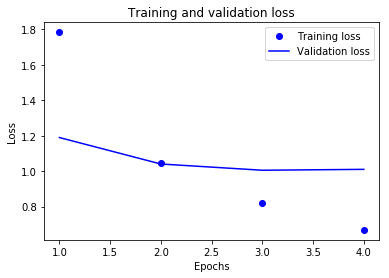

In [44]:
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

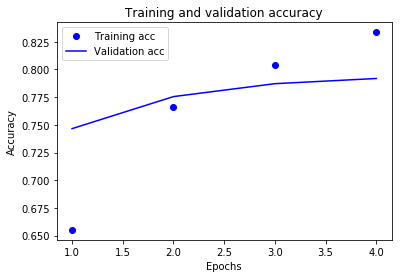

In [49]:
plt.clf()

acc = histtory.history['acc']
val_acc = histtory.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
histtory =rnn_model_with_embeddings.fit(x=X_train, 
                    y=Y_train, 
                    validation_data=(X_test, Y_test), 
                    batch_size=batch_size,  
                    epochs=2, 
                    verbose=1)

Train on 720000 samples, validate on 80000 samples
Epoch 1/2
  1024/720000 [..............................] - ETA: 53:49 - loss: 0.5084 - acc: 0.8604

In [43]:
#vocab_size=400000 without text cleaning
batch_size = 256
epochs = 6

rnn_model_with_embeddings.fit(x=X_train, 
                    y=Y_train, 
                    validation_data=(X_test, Y_test), 
                    batch_size=batch_size,  
                    epochs=epochs, 
                    verbose=1)

/root/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000000 elements. This may consume a large amount of memory.
  num_elements)


Train on 720000 samples, validate on 80000 samples
Epoch 1/6
720000/720000 [==============================] - 2966s 4ms/step - loss: 1.9659 - acc: 0.6337 - val_loss: 1.2719 - val_acc: 0.7391
Epoch 2/6
720000/720000 [==============================] - 3040s 4ms/step - loss: 1.1223 - acc: 0.7588 - val_loss: 1.0859 - val_acc: 0.7721
Epoch 3/6
720000/720000 [==============================] - 3038s 4ms/step - loss: 0.8958 - acc: 0.7970 - val_loss: 1.0320 - val_acc: 0.7826
Epoch 4/6
720000/720000 [==============================] - 3003s 4ms/step - loss: 0.7465 - acc: 0.8252 - val_loss: 1.0155 - val_acc: 0.7892
Epoch 5/6
720000/720000 [==============================] - 2998s 4ms/step - loss: 0.6317 - acc: 0.8482 - val_loss: 1.0169 - val_acc: 0.7931
Epoch 6/6
720000/720000 [==============================] - 2996s 4ms/step - loss: 0.5406 - acc: 0.8670 - val_loss: 1.0399 - val_acc: 0.7921


In [44]:
rnn_model_with_embeddings.save_weights('rnn_glove_4000000_no_filter.h5')

In [40]:
rnn_model_with_embeddings.load_weights('rnn_glove_4000000_no_filter.h5')

In [45]:
rnn_model_with_embeddings.fit(x=X_train, 
                    y=Y_train, 
                    validation_data=(X_test, Y_test), 
                    batch_size=batch_size,  
                    epochs=1, 
                    verbose=1)

Train on 720000 samples, validate on 80000 samples
Epoch 1/1
720000/720000 [==============================] - 2981s 4ms/step - loss: 0.4670 - acc: 0.8820 - val_loss: 1.0642 - val_acc: 0.7930


In [46]:
rnn_model_with_embeddings.fit(x=X_train, 
                    y=Y_train, 
                    validation_data=(X_test, Y_test), 
                    batch_size=batch_size,  
                    epochs=1, 
                    verbose=1)

Train on 720000 samples, validate on 80000 samples
Epoch 1/1
720000/720000 [==============================] - 2981s 4ms/step - loss: 0.4050 - acc: 0.8966 - val_loss: 1.0906 - val_acc: 0.7927


In [47]:
rnn_model_with_embeddings.save_weights('rnn_glove_4000000_no_filter_final.h5')

In [38]:
rnn_model_with_embeddings.load_weights('rnn_glove_4000000_no_filter_final.h5')

In [44]:
rnn_model_with_embeddings.fit(x=X_train, 
                    y=Y_train, 
                    validation_data=(X_test, Y_test), 
                    batch_size=256,  
                    epochs=2, 
                    verbose=1)

/root/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000000 elements. This may consume a large amount of memory.
  num_elements)


Train on 720000 samples, validate on 80000 samples
Epoch 1/2
720000/720000 [==============================] - 2931s 4ms/step - loss: 0.4462 - acc: 0.8924 - val_loss: 0.3623 - val_acc: 0.9141
Epoch 2/2
720000/720000 [==============================] - 2933s 4ms/step - loss: 0.3830 - acc: 0.9050 - val_loss: 0.3970 - val_acc: 0.9058


In [50]:
# Evaluate model
score, acc = rnn_model_with_embeddings.evaluate(X_test, Y_test, batch_size=128)
    
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

80000/80000 [==============================] - 22s 280us/step
Score: 1.0906
Accuracy: 0.7927


In [37]:
#vocab_size=100000
batch_size = 256
epochs = 4

rnn_model_with_embeddings.fit(x=X_train, 
                    y=Y_train, 
                    validation_data=(X_test, Y_test), 
                    batch_size=batch_size,  
                    epochs=epochs, 
                    verbose=1)

Train on 720000 samples, validate on 80000 samples
Epoch 1/4
720000/720000 [==============================] - 1393s 2ms/step - loss: 1.9547 - acc: 0.6375 - val_loss: 1.2721 - val_acc: 0.7360
Epoch 2/4
720000/720000 [==============================] - 1393s 2ms/step - loss: 1.1241 - acc: 0.7586 - val_loss: 1.0908 - val_acc: 0.7694
Epoch 3/4
720000/720000 [==============================] - 1394s 2ms/step - loss: 0.9187 - acc: 0.7923 - val_loss: 1.0245 - val_acc: 0.7827
Epoch 4/4
720000/720000 [==============================] - 1392s 2ms/step - loss: 0.7897 - acc: 0.8150 - val_loss: 0.9978 - val_acc: 0.7911


In [45]:
#vocab_size=400000
batch_size = 256
epochs = 4

rnn_model_with_embeddings.fit(x=X_train, 
                    y=Y_train, 
                    validation_data=(X_test, Y_test), 
                    batch_size=batch_size,  
                    epochs=epochs, 
                    verbose=1)

/root/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000000 elements. This may consume a large amount of memory.
  num_elements)


Train on 720000 samples, validate on 80000 samples
Epoch 1/4
720000/720000 [==============================] - 3160s 4ms/step - loss: 1.9530 - acc: 0.6368 - val_loss: 1.2566 - val_acc: 0.7394
Epoch 2/4
720000/720000 [==============================] - 3212s 4ms/step - loss: 1.1202 - acc: 0.7584 - val_loss: 1.0720 - val_acc: 0.7723
Epoch 3/4
720000/720000 [==============================] - 3212s 4ms/step - loss: 0.9093 - acc: 0.7939 - val_loss: 1.0131 - val_acc: 0.7857
Epoch 4/4
720000/720000 [==============================] - 3211s 4ms/step - loss: 0.7736 - acc: 0.8181 - val_loss: 0.9900 - val_acc: 0.7931


In [ ]:
rnn_model_with_embeddings.fit(x=X_train, 
                    y=Y_train, 
                    validation_data=(X_test, Y_test), 
                    batch_size=batch_size,  
                    epochs=2, 
                    verbose=1)

Train on 720000 samples, validate on 80000 samples
Epoch 1/2
491008/720000 [===================>..........] - ETA: 16:51 - loss: 0.6683 - acc: 0.8384

In [68]:
# Evaluate model
score, acc = rnn_model_with_embeddings.evaluate(X_test, Y_test, batch_size=128)
    
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

160000/160000 [==============================] - 51s 321us/step
Score: 1.0001
Accuracy: 0.7969


In [36]:
embedding_matrix.shape

(400000, 300)

In [15]:
def get_rnn_cnn_model():
    embedding_dim = 300
    inp = Input(shape=(MAX_LENGTH, ))
    x = Embedding(MAX_NB_WORDS, embedding_dim, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)(inp)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(GRU(100, return_sequences=True))(x)
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(3008, activation="softmax")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
rnn_cnn_model = get_rnn_cnn_model()


In [49]:
batch_size = 256
epochs = 4

rnn_cnn_model.fit(x=X_train, 
                    y=Y_train, 
                    validation_data=(X_test, Y_test), 
                    batch_size=batch_size,  
                    epochs=epochs, 
                    verbose=1)

Train on 720000 samples, validate on 80000 samples
Epoch 1/4
720000/720000 [==============================] - 2905s 4ms/step - loss: 1.9544 - acc: 0.6325 - val_loss: 1.2950 - val_acc: 0.7335
Epoch 2/4
720000/720000 [==============================] - 2909s 4ms/step - loss: 1.1711 - acc: 0.7503 - val_loss: 1.1302 - val_acc: 0.7643
Epoch 3/4
720000/720000 [==============================] - 2908s 4ms/step - loss: 0.9533 - acc: 0.7870 - val_loss: 1.0824 - val_acc: 0.7759
Epoch 4/4
720000/720000 [==============================] - 2911s 4ms/step - loss: 0.8084 - acc: 0.8133 - val_loss: 1.0717 - val_acc: 0.7821


In [52]:
# Evaluate model
score, acc = rnn_cnn_model.evaluate(X_test, Y_test, batch_size=128)
    
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

80000/80000 [==============================] - 22s 281us/step
Score: 1.0717
Accuracy: 0.7821


In [75]:

history=rnn_cnn_model.fit(x=X_train, 
                    y=Y_train, 
                    validation_data=(X_test, Y_test), 
                    batch_size=batch_size, 
                    epochs=2, 
                    verbose=1)

Train on 640000 samples, validate on 160000 samples
Epoch 1/2
640000/640000 [==============================] - 1009s 2ms/step - loss: 0.7066 - acc: 0.8308 - val_loss: 1.0544 - val_acc: 0.7906
Epoch 2/2
640000/640000 [==============================] - 1009s 2ms/step - loss: 0.6447 - acc: 0.8431 - val_loss: 1.0736 - val_acc: 0.7922


In [78]:
rnn_cnn_model.fit(x=X_train, 
                    y=Y_train, 
                    validation_data=(X_test, Y_test), 
                    batch_size=batch_size, 
                    epochs=2, 
                    verbose=1)

Train on 640000 samples, validate on 160000 samples
Epoch 1/2
640000/640000 [==============================] - 1089s 2ms/step - loss: 0.5936 - acc: 0.8530 - val_loss: 1.0989 - val_acc: 0.7925
Epoch 2/2
640000/640000 [==============================] - 1088s 2ms/step - loss: 0.5497 - acc: 0.8620 - val_loss: 1.1169 - val_acc: 0.7938


In [79]:
rnn_cnn_model.save_weights('rnn_cnn_model.h5')

In [37]:
rnn_cnn_model.load_weights('rnn_cnn_model.h5')

ValueError: Cannot feed value of shape (80000, 300) for Tensor u'embedding_1/Placeholder:0', which has shape '(400000, 300)'

In [77]:
# Evaluate model
score, acc = rnn_cnn_model.evaluate(X_test, Y_test, batch_size=128)
    
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

160000/160000 [==============================] - 47s 292us/step
Score: 1.0736
Accuracy: 0.7922


In [51]:
pred=model_lstm.predict(X_test,batch_size=32, verbose=1)

160000/160000 [==============================] - 28s 177us/step


In [52]:
predicted = np.argmax(pred, axis=1)

In [53]:
from sklearn.metrics import classification_report

In [57]:
from sklearn.metrics import precision_recall_fscore_support

In [55]:
report = classification_report(np.argmax(Y_test, axis=1), predicted)

/root/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [58]:
weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(np.argmax(Y_test, axis=1), predicted, pos_label=None, average='weighted')

In [59]:
weighted_p

0.848261943495386

In [60]:
weighted_r

0.8489125

In [61]:
weighted_f1

0.8426649396539287

In [35]:
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(vocabulary_size, 100, input_length=50))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(100))
    model_conv.add(Dense(3008, activation='softmax'))
    model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_conv

In [36]:
model_conv = create_conv_model()
model_conv.fit(data, dummy_y, validation_split=0.2, epochs = 3)

Train on 640000 samples, validate on 160000 samples
Epoch 1/3
640000/640000 [==============================] - 2373s 4ms/step - loss: 3.7496 - acc: 0.3816 - val_loss: 2.3075 - val_acc: 0.5913
Epoch 2/3
640000/640000 [==============================] - 2375s 4ms/step - loss: 2.0413 - acc: 0.6238 - val_loss: 1.9150 - val_acc: 0.6475
Epoch 3/3
188224/640000 [=======>......................] - ETA: 27:43 - loss: 1.7284 - acc: 0.6672

KeyboardInterrupt: 

In [34]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [35]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [36]:
embedding_matrix.shape

(100000, 100)

In [37]:
embedding_layer = Embedding(vocabulary_size,
                            100,
                            weights=[embedding_matrix],
                            input_length=1000,
                            trainable=False)

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(data, dummy_y, test_size=0.2)

In [40]:
from keras.layers import Input
from keras.models import Model

In [42]:
sequence_input = Input(shape=(1000,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(3008, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
          epochs=2, batch_size=128)

Train on 640000 samples, validate on 160000 samples
Epoch 1/2
640000/640000 [==============================] - 1925s 3ms/step - loss: 6.2993 - acc: 0.0868 - val_loss: 5.6567 - val_acc: 0.0876
Epoch 2/2
640000/640000 [==============================] - 1925s 3ms/step - loss: 5.6941 - acc: 0.0873 - val_loss: 5.7548 - val_acc: 0.0876


In [19]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(3008, activation='softmax'))
model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
from sklearn.cross_validation import train_test_split

/root/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(data, dummy_y, test_size=0.2)

In [23]:
# Train model
model_glove.fit(X_train, Y_train, nb_epoch=3, validation_data=(X_test, Y_test))

/root/anaconda2/lib/python2.7/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 640000 samples, validate on 160000 samples
Epoch 1/3
640000/640000 [==============================] - 287s 448us/step - loss: 5.6791 - acc: 0.0876 - val_loss: 5.6751 - val_acc: 0.0864
Epoch 2/3
267936/640000 [===========>..................] - ETA: 2:35 - loss: 5.6560 - acc: 0.0875

KeyboardInterrupt: 

In [70]:
print("read data")
test_df=pd.read_csv('rdc-catalog-test.tsv',delimiter='\t',header=None,encoding='utf-8')
print("finished reading")
test_df.columns = ['Title','label']

read data
finished reading


In [71]:
test_df.head()

,Title,label
0,Title,CategoryIdPath
1,Sterling Silver Dangle Ball Earrings w/ Brilli...,1608>2320>2173>3813
2,ALTERNATOR FREIGHTLINER FL FLC 112 120 FLD 112...,2199>4592>12
3,Disc Brake Rotor-Advanced Technology Rear Rayb...,2199>4592>12
4,Coquette Neon Pink Ruffle Babydoll 7035 Neon P...,1608>4269>3031>1221


In [75]:
elem= np.array(test_df['Title'])[1]

In [76]:
elem

u'Sterling Silver Dangle Ball Earrings w/ Brilliant Cut CZ Stones & Yellow Topaz-colored Crystal Balls, 1" (26 mm) tall'

In [85]:
#tokenizer = Tokenizer(num_words= vocabulary_size)
#tokenizer.fit_on_texts(elem)

sequences = tokenizer.texts_to_sequences(test_df['Title'])
token_elem = pad_sequences(sequences, maxlen=50)

In [86]:
token_elem.shape

(200001, 50)

In [83]:
tokenizer.word_index

{u'6007200': 161449,
 u'mdbc': 321592,
 u'dv6912tx': 145071,
 u'woodi': 6911,
 u'gw166': 313807,
 u'0t557c': 407344,
 u'mp36t': 362587,
 u'89371': 248130,
 u'89374': 127658,
 u'paizo': 62444,
 u'st500lt025': 132619,
 u'ca15g9': 367286,
 u'calvecin': 198964,
 u'ysb12': 148546,
 u'5989': 56093,
 u'gam162': 190946,
 u'unigvp': 211940,
 u'5982': 300126,
 u'5983': 110134,
 u'12kpag': 187786,
 u'5981': 63288,
 u'stimulskin': 42473,
 u'aleeqa42me10a': 81215,
 u'mp180': 48359,
 u'15blk': 136199,
 u'propolymax': 328714,
 u'4134632': 194780,
 u'1d46dx': 341888,
 u'w0s23ut': 262987,
 u'10659207992': 204314,
 u'pigment': 5197,
 u'mdb4': 341103,
 u'218136': 230595,
 u'pu102882008': 327459,
 u'pd600401': 144577,
 u'48tjd0161a0': 284722,
 u'weeli': 212846,
 u'fz160e': 60335,
 u'flor00023': 299235,
 u'wooden': 1094,
 u'gencov': 362645,
 u'598p': 206661,
 u'durable3pc': 227851,
 u'shchedrin': 70287,
 u'n211nr': 124839,
 u'11400710': 130430,
 u'sv2zomxl': 405885,
 u'woodez': 44495,
 u'convi': 65607,
 u'

In [84]:
??tokenizer.texts_to_sequences

In [87]:
test_pred=model_lstm.predict(token_elem,batch_size=32, verbose=1)

200001/200001 [==============================] - 35s 176us/step


In [88]:
test_predicted = np.argmax(test_pred, axis=1)

In [89]:
test_predicted

array([1020,  391,  851, ..., 1788, 2619, 1396])

In [97]:
test_df.insert(2,'keras_label',[encoder.classes_[pred] for pred in test_predicted.tolist()])

In [98]:
test_df

,Title,label,keras_label
0,Title,CategoryIdPath,2296>3597>689
1,Sterling Silver Dangle Ball Earrings w/ Brilli...,1608>2320>2173>3813,1608>2320>498>1546
2,ALTERNATOR FREIGHTLINER FL FLC 112 120 FLD 112...,2199>4592>12,2199>4592>12
3,Disc Brake Rotor-Advanced Technology Rear Rayb...,2199>4592>12,2199>4592>12
4,Coquette Neon Pink Ruffle Babydoll 7035 Neon P...,1608>4269>3031>1221,1608>1206>1632>4604
5,12V 7Ah (SPS Brand) APC NS3000RMT3U Replacemen...,3292>114>1231,3292>114>1231
6,Honda Ridgeline 2006-08 Black Radio AM FM 6 Di...,3292>2790>350,3292>2790>350
7,Morris Costumes SS88229 Rat Pumpkin Push In,92,2296>3706>1586
8,Benzara Alphabet Sculpture ''and '' Sign Polis...,4015>3636>526>2454>882,4015>3636>526>2454>882
9,Ana Silver Co Rainbow Moonstone Earrings 2 1/4...,1608>2320>2173>3813,1608>2320>2495>4952


In [100]:
test_df=test_df.drop('label',axis=1)

In [101]:
test_df

,Title,keras_label
0,Title,2296>3597>689
1,Sterling Silver Dangle Ball Earrings w/ Brilli...,1608>2320>498>1546
2,ALTERNATOR FREIGHTLINER FL FLC 112 120 FLD 112...,2199>4592>12
3,Disc Brake Rotor-Advanced Technology Rear Rayb...,2199>4592>12
4,Coquette Neon Pink Ruffle Babydoll 7035 Neon P...,1608>1206>1632>4604
5,12V 7Ah (SPS Brand) APC NS3000RMT3U Replacemen...,3292>114>1231
6,Honda Ridgeline 2006-08 Black Radio AM FM 6 Di...,3292>2790>350
7,Morris Costumes SS88229 Rat Pumpkin Push In,2296>3706>1586
8,Benzara Alphabet Sculpture ''and '' Sign Polis...,4015>3636>526>2454>882
9,Ana Silver Co Rainbow Moonstone Earrings 2 1/4...,1608>2320>2495>4952


In [102]:
test_df=test_df.drop(test_df.index[0])

In [103]:
test_df

,Title,keras_label
1,Sterling Silver Dangle Ball Earrings w/ Brilli...,1608>2320>498>1546
2,ALTERNATOR FREIGHTLINER FL FLC 112 120 FLD 112...,2199>4592>12
3,Disc Brake Rotor-Advanced Technology Rear Rayb...,2199>4592>12
4,Coquette Neon Pink Ruffle Babydoll 7035 Neon P...,1608>1206>1632>4604
5,12V 7Ah (SPS Brand) APC NS3000RMT3U Replacemen...,3292>114>1231
6,Honda Ridgeline 2006-08 Black Radio AM FM 6 Di...,3292>2790>350
7,Morris Costumes SS88229 Rat Pumpkin Push In,2296>3706>1586
8,Benzara Alphabet Sculpture ''and '' Sign Polis...,4015>3636>526>2454>882
9,Ana Silver Co Rainbow Moonstone Earrings 2 1/4...,1608>2320>2495>4952
10,Kiehl's Creme de Corps Whipped Body Butter - S...,3625>594>3088


In [108]:
test_df.to_csv("submission_keras.tsv", sep='\t', encoding='utf-8',index=False,header=False)

In [109]:
sub_df=pd.read_csv("submission_keras.tsv",delimiter='\t',encoding='utf-8',header=None)

In [110]:
sub_df

,0,1
0,Sterling Silver Dangle Ball Earrings w/ Brilli...,1608>2320>498>1546
1,ALTERNATOR FREIGHTLINER FL FLC 112 120 FLD 112...,2199>4592>12
2,Disc Brake Rotor-Advanced Technology Rear Rayb...,2199>4592>12
3,Coquette Neon Pink Ruffle Babydoll 7035 Neon P...,1608>1206>1632>4604
4,12V 7Ah (SPS Brand) APC NS3000RMT3U Replacemen...,3292>114>1231
5,Honda Ridgeline 2006-08 Black Radio AM FM 6 Di...,3292>2790>350
6,Morris Costumes SS88229 Rat Pumpkin Push In,2296>3706>1586
7,Benzara Alphabet Sculpture ''and '' Sign Polis...,4015>3636>526>2454>882
8,Ana Silver Co Rainbow Moonstone Earrings 2 1/4...,1608>2320>2495>4952
9,Kiehl's Creme de Corps Whipped Body Butter - S...,3625>594>3088
